<a href="https://colab.research.google.com/github/lucius-yu/colab-tutorial/blob/master/kfold_average_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KFlod Average on DNN for fashion mnist problem

Import liberary

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score

Load the data, preprocess the data, setup KFold CV

In [2]:
mnist = tf.keras.datasets.fashion_mnist

# load data
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

# normalization
training_images  = training_images / 255.0
test_images = test_images / 255.0

4423680/4422102 [==============================] - 0s 0us/step


Build the model

In [0]:
def get_model(layers=[128,128],dropout=0.0, lr=0.0005):
  # construct the model
  model = tf.keras.Sequential()
  # add flatten layer, flatten 2-dim data into 1-dim vector
  model.add(tf.keras.layers.Flatten())
  # add middle layer
  for num_units in layers:
    model.add(tf.keras.layers.Dense(num_units, activation='relu'))
    if dropout>0:
      model.add(tf.keras.layers.Dropout(rate=dropout))
      
  # add output layer, i.e. 10 class softmax
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
  
  # compile
  model.compile(optimizer = tf.train.AdamOptimizer(learning_rate=lr),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

Train KFold Model

In [14]:
# setup cv
skf = StratifiedKFold(n_splits=5)

# variables
num_epochs=40

# predictions
test_preds = list()

# history
train_history = list()

# early stopping
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),]

for train_index, validation_index in skf.split(training_images, training_labels):
  print("TRAIN:", len(train_index), "Validation:", len(validation_index))
  
  X_train, X_valid = training_images[train_index], training_images[validation_index]
  y_train, y_valid = training_labels[train_index], training_labels[validation_index]
  
  dnn_model = get_model(dropout=0.0)
  history = dnn_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[], epochs=num_epochs)
  train_history.append(history)
  
  # evaluate on test images
  dnn_model.evaluate(test_images, test_labels)
  
  # record test_preds
  test_preds.append(dnn_model.predict(test_images, batch_size=128))

TRAIN: 48000 Validation: 12000
Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 7s 139us/sample - loss: 0.6423 - acc: 0.7722 - val_loss: 0.4193 - val_acc: 0.8478
Epoch 2/40
48000/48000 [==============================] - 6s 129us/sample - loss: 0.4490 - acc: 0.8388 - val_loss: 0.3852 - val_acc: 0.8572
Epoch 3/40
48000/48000 [==============================] - 6s 126us/sample - loss: 0.4070 - acc: 0.8512 - val_loss: 0.3689 - val_acc: 0.8644
Epoch 4/40
48000/48000 [==============================] - 6s 128us/sample - loss: 0.3802 - acc: 0.8606 - val_loss: 0.3357 - val_acc: 0.8767
Epoch 5/40
48000/48000 [==============================] - 6s 123us/sample - loss: 0.3614 - acc: 0.8681 - val_loss: 0.3259 - val_acc: 0.8812
Epoch 6/40
48000/48000 [==============================] - 6s 123us/sample - loss: 0.3487 - acc: 0.8699 - val_loss: 0.3360 - val_acc: 0.8765
Epoch 7/40
48000/48000 [==============================] - 6s 122us/sample - los

In [15]:
for i in range(len(test_preds)):
  print("{}th Model: loss={} accuracy={}".format(i,log_loss(test_labels,test_preds[i]),accuracy_score(test_labels,np.argmax(test_preds[i],axis=1))))

kfold_test_preds = np.average(np.array(test_preds),axis=0)
print("KFold Average Model: loss={} accuracy={}".format(log_loss(test_labels,kfold_test_preds),accuracy_score(test_labels,np.argmax(kfold_test_preds,axis=1))))

0th Model: loss=0.3212256893149229 accuracy=0.886
1th Model: loss=0.32108393190566814 accuracy=0.8878
2th Model: loss=0.3205704803523238 accuracy=0.8894
3th Model: loss=0.3238184029274046 accuracy=0.8883
4th Model: loss=0.322831092272229 accuracy=0.8879
KFold Average Model: loss=0.28889486623470273 accuracy=0.8965


Plot history

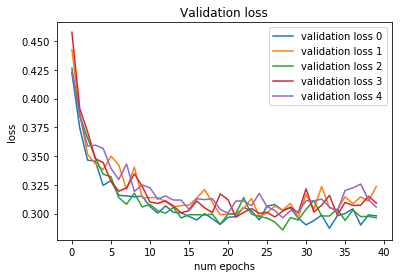

In [13]:
for i in range(len(train_history)):
  history = train_history[i]
  plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label="validation loss {}".format(i))

plt.xlabel("num epochs")
plt.ylabel("loss")
plt.title("Validation loss")
plt.legend()